In [1]:
import sys
sys.path.append('../')
import sqlite3
import json
from backtester import *
from fxcmtoken import major_forex_pairs
from sklearn.model_selection import train_test_split
from datetime import datetime
major_forex_pairs

freq = 'H1'
conn = sqlite3.connect(f'../PriceData/PriceData_{freq}.db')
ticker = major_forex_pairs[0]
print(ticker)
data = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
conn.close()
columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
display(data)

EUR/USD


,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2020-08-10 21:00:00,1.17370,1.17378,1.17399,1.17353,1.17393,1.17405,1.17457,1.17372,1176,1.173815,1.174280,1.173625,1.173915
2020-08-10 22:00:00,1.17378,1.17410,1.17421,1.17354,1.17405,1.17423,1.17437,1.17366,2350,1.173915,1.174290,1.173600,1.174165
2020-08-10 23:00:00,1.17410,1.17355,1.17425,1.17352,1.17423,1.17367,1.17438,1.17364,3122,1.174165,1.174315,1.173580,1.173610
2020-08-11 00:00:00,1.17355,1.17241,1.17370,1.17214,1.17367,1.17253,1.17382,1.17227,8813,1.173610,1.173760,1.172205,1.172470
2020-08-11 01:00:00,1.17241,1.17438,1.17470,1.17226,1.17253,1.17450,1.17480,1.17238,8050,1.172470,1.174750,1.172320,1.174440
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-09 01:00:00,1.09134,1.09134,1.09195,1.09095,1.09149,1.09147,1.09211,1.09110,6724,1.091415,1.092030,1.091025,1.091405
2022-03-09 02:00:00,1.09133,1.09155,1.09196,1.09118,1.09147,1.09169,1.09210,1.09132,5046,1.091400,1.092030,1.091250,1.091620
2022-03-09 03:00:00,1.09155,1.09066,1.09168,1.09046,1.09168,1.09081,1.09183,1.09059,4755,1.091615,1.091755,1.090525,1.090735


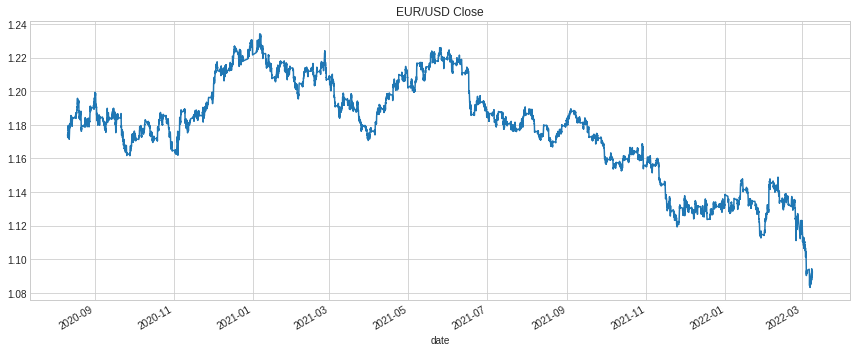

In [2]:
data.close.plot(figsize=(12,5), title=f"{ticker} Close")
plt.tight_layout()
plt.show()

In [3]:
# get indicators

# EMA
ema_window = 500
data['ema'] = talib.EMA(data.close, ema_window)

# RSI
rsi_window = 50
data['rsi'] = talib.RSI(data.close, rsi_window)

# Bollinger bands
bb_window = 500
data['bb_upper'], data['bb_mid'], data['bb_lower'] = talib.BBANDS(data.close, bb_window)

data.dropna(axis=0, inplace=True)
display(data.iloc[-5:, -5:])
print(data.shape)

,ema,rsi,bb_upper,bb_mid,bb_lower
date,,,,,
2022-03-09 01:00:00,1.116706,47.173126,1.157682,1.123415,1.089148
2022-03-09 02:00:00,1.116606,47.361471,1.157658,1.123314,1.088970
2022-03-09 03:00:00,1.116503,46.662680,1.157636,1.123211,1.088786
2022-03-09 04:00:00,1.116404,47.519757,1.157613,1.123112,1.088610
2022-03-09 05:00:00,1.116309,48.414069,1.157580,1.123013,1.088446


(9501, 18)


In [4]:
# get signals

# EMA
data['ema_signal'] = np.where(data.close > data.ema, 1, -1)

# RSI
data['rsi_signal'] = np.where(data.rsi > 70, -1, 
                     np.where(data.rsi < 30, 1, np.nan))
data['rsi_less_50'] = np.where(data.rsi < 50, 1, -1)
data.loc[(data.rsi_less_50 * data.rsi_less_50.shift(1) < 0), 'rsi_signal'] = 0
data.rsi_signal.ffill(inplace=True)
data.rsi_signal.fillna(0, inplace=True)

# BB
data['bb_signal'] = np.where(data.close > data.bb_upper, -1, 
                    np.where(data.close < data.bb_lower, 1, np.nan))
data['bb_less_mid'] = np.where(data.close < data.bb_mid, 1, -1)
data.loc[(data.bb_less_mid * data.bb_less_mid.shift(1) < 0), 'bb_signal'] = 0
data.bb_signal.ffill(inplace=True)
data.bb_signal.fillna(0, inplace=True)

In [5]:
signal_cols = ['ema_signal', 'rsi_signal', 'bb_signal']
data.loc[:,signal_cols]

,ema_signal,rsi_signal,bb_signal
date,,,
2020-09-08 09:00:00,-1,0.0,0.0
2020-09-08 10:00:00,-1,0.0,0.0
2020-09-08 11:00:00,-1,0.0,0.0
2020-09-08 12:00:00,-1,0.0,0.0
2020-09-08 13:00:00,-1,0.0,0.0
...,...,...,...
2022-03-09 01:00:00,-1,0.0,1.0
2022-03-09 02:00:00,-1,0.0,1.0
2022-03-09 03:00:00,-1,0.0,1.0


In [6]:
signals = data.loc[:,signal_cols].mode(axis=1).iloc[:, 0]

In [7]:
signals.value_counts(normalize=True)*100

-1.0    59.962109
 0.0    36.806652
 1.0     3.231239
Name: 0, dtype: float64

  0%|          | 0/9500 [00:00<?, ?it/s]

/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


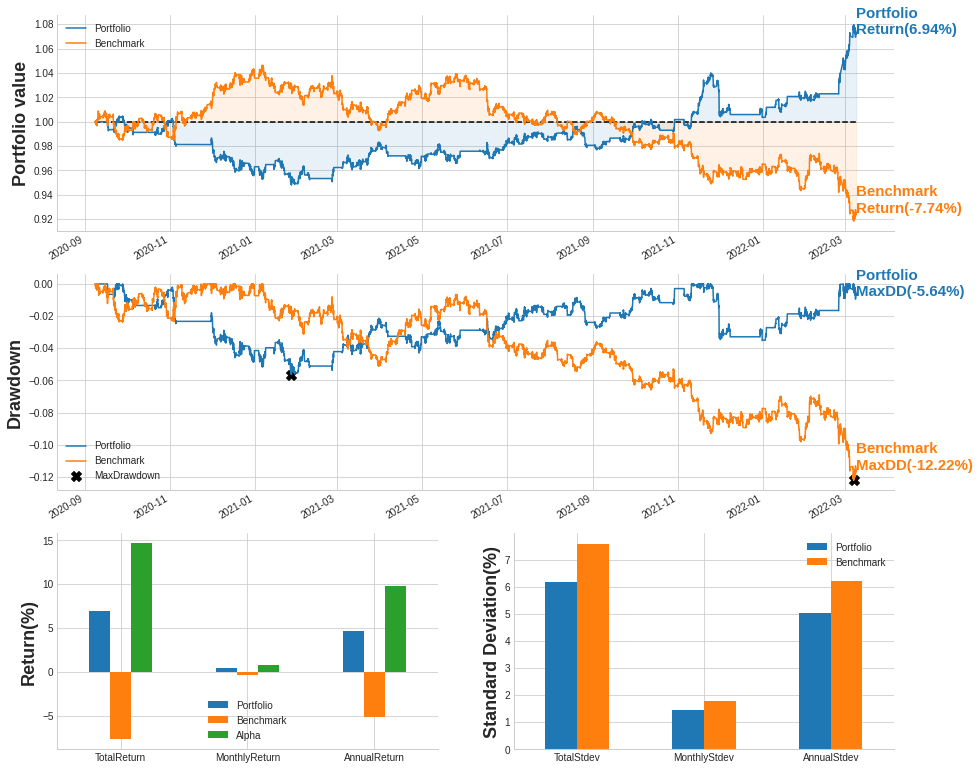

----------------------------------------------------------------------
Data length: |546 days 20:00:00|
Data range from |2020-09-08 09:00:00| to |2022-03-09 05:00:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │       6.941 │      -7.737 │  14.678 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │       0.381 │      -0.424 │   0.805 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │       4.633 │      -5.164 │   9.797 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │  

In [8]:
backtest = IterativeBacktester(data=data, signals=signals, freq=freq)
backtest.backtest()
backtest.results()